<a href="https://colab.research.google.com/github/hectorcamachoz/LDA_Arboles_de_Decisiones/blob/main/A2_2_594557.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDA y Árboles de Decisiones

1. Se utilizara la base de datos del repositorio llamado Proyecto_1_InteligenciaArtificial, por lo tanto, se aplicaran todas las modificaciones que se hicieron a la base de datos en esa actividad, si quisieras conocer el porque de cada modificacion, lo podras encontrar en el repositorio mencionado.

  Para comenzar se importaran los datos y se hara una particion 80 - 20 manteniendo un balance en las clases.

In [12]:
import pandas as pd

df = pd.read_csv('day.csv')
df = df.drop('instant', axis=1)
df = df.drop('dteday', axis= 1)
df = df.drop('mnth', axis = 1)
df = df.drop('weekday', axis=1)
df = pd.get_dummies(df, columns=['season', 'weathersit'],drop_first=False, dtype = int)
df = df.drop('atemp', axis = 1)

df = df.drop('casual', axis = 1)
df = df.drop('registered', axis = 1)

renta_del_dia = []

for i in df['cnt']:
    if i >= 2500:
        renta_del_dia.append(1)
    else:
        renta_del_dia.append(0)
df = pd.concat([df, pd.Series(renta_del_dia, name='renta_del_dia')], axis=1)
df = df.drop('cnt', axis = 1)
df.head()

print(df.renta_del_dia.value_counts())

x = df.drop('renta_del_dia', axis = 1)
y = df['renta_del_dia']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)

print("Distribución en y:\n", y.value_counts(normalize=True))
print("\nDistribución en y_train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en y_test:\n", y_test.value_counts(normalize=True))

renta_del_dia
1    587
0    144
Name: count, dtype: int64
Distribución en y:
 renta_del_dia
1    0.80301
0    0.19699
Name: proportion, dtype: float64

Distribución en y_train:
 renta_del_dia
1    0.803082
0    0.196918
Name: proportion, dtype: float64

Distribución en y_test:
 renta_del_dia
1    0.802721
0    0.197279
Name: proportion, dtype: float64


2. A continuacion se utilizara la funcion GLM de la libreria statsmodels, para realizar una regresion logistica simple para detectar cuales son las dos variables mas relevantes.


In [13]:
import statsmodels.api as sm
md_glm = sm.GLM(y_train, sm.add_constant(x_train), family=sm.families.Binomial())
res_glm = md_glm.fit()
print(res_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          renta_del_dia   No. Observations:                  584
Model:                            GLM   Df Residuals:                      572
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86.929
Date:                Thu, 20 Mar 2025   Deviance:                       173.86
Time:                        01:47:03   Pearson chi2:                     979.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5007
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8477      1.053     -2.704   

Al observar los resultados del generalized linear model, podemos concluir que este modelo se ajusta al 50% de los datos. De acuerdo a chatGPT, otra de las formas para medir la calidad del modelo es con el Log-Likelihood, entre mas cercana a 0 mejor, en este caso dio como resultado -86.9. Para seleccionar las dos variables mas siginificativas, se tomara en cuenta el P-value, por lo tanto se eligira la variable yr (año) y la variable de temp (Temperatura).

In [14]:
x_train = x_train.filter(items=['yr', 'temp'])
x_test = x_test.filter(items=['yr', 'temp'])


     yr      temp
89    0  0.268333
181   0  0.722500
650   1  0.437500
147   0  0.655833
349   0  0.375000
..   ..       ...
340   0  0.410000
428   1  0.325833
425   1  0.485833
361   0  0.299130
400   1  0.265833

[584 rows x 2 columns]


3. Se generara otro modelo, esta vez utilizando la funcion LinearDiscriminantAnalysis de sklearn.discriminant_analysis, y se realizara una grafica para una observacion mas sencilla

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


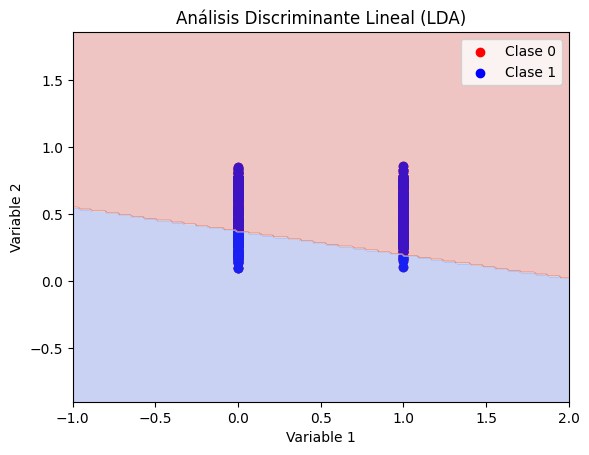

In [20]:
import sklearn.discriminant_analysis as LDA
import matplotlib.pyplot as plt
import numpy as np

colors = {0: 'red', 1: 'blue'}
md_LDA = LDA.LinearDiscriminantAnalysis()
md_LDA.fit(x_train, y_train)
y_pred_proba = md_LDA.predict_proba(x_test)
y_pred = md_LDA.predict(x_test)
for clase in np.unique(y):
    plt.scatter(x_train['yr'],
                x_train['temp'],
                color=colors[clase],
                label=f'Clase {clase}')

# Trazar la frontera de decisión
x_min, x_max = x_train['yr'].min() - 1, x_train['yr'].max() + 1
y_min, y_max = x_train['temp'].min() - 1, x_train['temp'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
Z = md_LDA.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title('Análisis Discriminante Lineal (LDA)')
plt.legend()
plt.show()